# BICYCLE DATA QUALITY

## (01a) Load & process OSM data

**Overview:**

This notebook:
- Loads the polygon defining the study area and then creates a grid overlay for the study area.
- Downloads street network data for the study area using OSMnx.
- Creates a network only with bicycle infrastructure (with queries defined in `config.yml`).
- Creates additional attributes in the data to be used in the analysis.

Output files of this notebook are saved to the `../data/OSM/'study_area'/processed/` subfolder and used in notebook 02a, 03a and 03b.

***

**Sections:**

1. Load data for study area & define grid used for computation local results.

2. Load OSM data.
_______________________

### 1. Load data for study area & define grid

This step:

- Loads settings for the analysis from the config file.
- Reads data for the study area.
- Creates a grid overlay of the study area, with grid cell size as defined in configuration file `config.yml`.

In [1]:
import json
import pickle
from datetime import datetime

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import yaml
import warnings

from src import evaluation_functions as eval_func
from src import graph_functions as graph_func
from src import simplification_functions as simp_func

%run ../settings/plotting.py
%run ../settings/yaml_variables.py
%run ../settings/paths.py

warnings.filterwarnings('ignore')

#### Read in data for study area

The size of the study area is 181.38 square kilometers


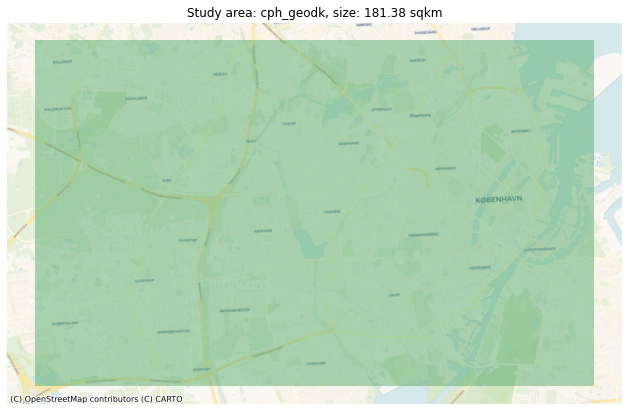

In [2]:
# Read polygon for study area
study_area_poly = gpd.read_file(study_area_poly_fp)

if study_area_poly.crs == None:
    print("Please assign a crs to the study area polygon!")

if study_area_poly.crs != study_crs:
    study_area_poly = study_area_poly.to_crs(study_crs)

assert study_area_poly.crs == study_crs

area = study_area_poly.area.values[0]
print(f"The size of the study area is {area / 1000000:.2f} square kilometers")

fig, ax = plt.subplots(1, figsize=pdict["fsmap"])

study_area_poly.plot(ax=ax, color=pdict["base"], alpha=pdict["alpha_back"])

ax.set_axis_off()

cx.add_basemap(ax, crs=study_area_poly.crs, source=cx_tile_1)

ax.set_title(f"Study area: {study_area}, size: {area / 1000000:.2f} sqkm")

fig.savefig(osm_results_static_maps_fp + "area_size_OSM.png", dpi=pdict["dpi"])

#### Create grid to be used in the analysis

<div class="alert alert-block alert-info">
<b>User configurations</b>
<br>
<br>
The grid is used to compute local results for many of the quality metrics. The cell size of the grid cells must be specified in the configuration file. Smaller grid cells will increase the computation time but give a more granular result. The grid cell size should not be smaller than the scale at which you would expect actual differences in data quality.
</div>

The grid contains 770 square cells with a side length of 500m and an area of 0.25 square kilometers.


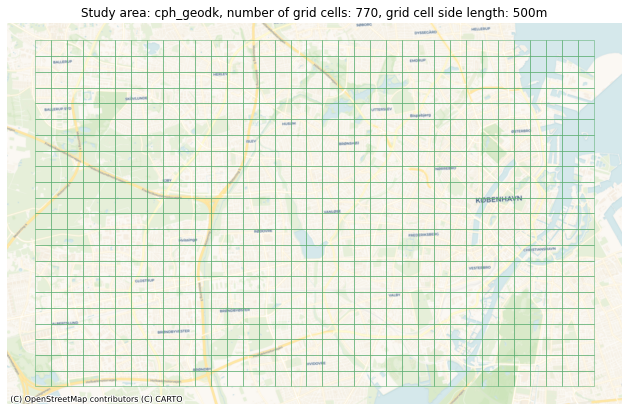

In [3]:
grid = eval_func.create_grid_geometry(study_area_poly, grid_cell_size)

grid["grid_id"] = grid.index

fig, ax = plt.subplots(1, figsize=pdict["fsmap"])

grid_cell_area = (grid_cell_size / 1000) ** 2  # in km2
print(
    f"The grid contains {len(grid)} square cells with a side length of {grid_cell_size}m and an area of {grid_cell_area:.2f} square kilometers."
)

grid.plot(ax=ax, facecolor="none", edgecolor=pdict["base"], alpha=pdict["alpha_back"])

ax.set_axis_off()

cx.add_basemap(ax, crs=study_area_poly.crs, source=cx_tile_1)

ax.set_title(
    f"Study area: {study_area}, number of grid cells: {len(grid)}, grid cell side length: {grid_cell_size}m"
)

fig.savefig(osm_results_static_maps_fp + "area_grid_OSM.png", dpi=pdict["dpi"])

### 2. Load OSM data

This step:

- Downloads data from OpenStreetMap using OSMnx.
- Projects the data to the chosen CRS.
- Creates a subnetwork consisting only of bicycle infrastructure.
- Classifies all edges in the bicycle network based on whether they are protected or unprotected bicycle infrastructure, how they have been digitized, and whether they allow for bidirectional travel or not
- Simplifies the network *(to read more about the modified OSMnx simplification (Boeing, 2017) used here, we refer to this [GitHub repository](https://github.com/anerv/NERDS_osmnx) which contains both the simplification functions, explanation of the logic and a demonstration)*.
- Creates copies of all edge and node datasets indexed by their intersecting grid cell.

Depending on the size of your study area, getting data through OSMnx can take a little while (for a city around the size of Copenhagen, it usually takes 1-2 minutes).

<div class="alert alert-block alert-info">
<b>User configurations</b>
<br>
<br>
In the following the dedicated bicycle infrastructure is extracted from the general street network. Depending on the type of bicycle infrastructure and OSM tagging tradition in your area, the queries used for retrieving the bicycle network might need to be adapted (this is done in the configuration file under <i>bicycle_infrastructure_queries</i>).
</div>

In [4]:
### Download OSM data
ox.settings.use_cache = False
ox.settings.useful_tags_way = osm_way_tags

graph_osm = ox.graph_from_polygon(
    study_area_poly.to_crs("EPSG:4326").loc[0, "geometry"],
    network_type="bike",
    simplify=False,
    retain_all=True,
    truncate_by_edge=False,
    clean_periphery=True,
)

print("OSM data retrieved successfully!")

OSM data retrieved successfully!


In [5]:
### CONVERT INTO GRAPH

# Project graph to chosen crs
graph_osm = ox.project_graph(graph_osm, to_crs=study_crs)

# Get osm_edges and osm_nodes
osm_nodes, osm_edges = ox.graph_to_gdfs(graph_osm)

# Clean up column names (removing ':' and upper case letters)
osm_edges = graph_func.clean_col_names(osm_edges)
osm_nodes = graph_func.clean_col_names(osm_nodes)

# Add attribute on whether bicycle infra exist or not (to be used by e.g. simplification function)
osm_edges["bicycle_infrastructure"] = "no"

for q in bicycle_infrastructure_queries.values():

    try:
        ox_filtered = osm_edges.query(q)

    except Exception:
        print("Exception occured when quering with:", q)
        print("Please check if the columns used in the query are present in the data")

    osm_edges.loc[ox_filtered.index, "bicycle_infrastructure"] = "yes"

osm_edges.bicycle_infrastructure.value_counts()

bicycle_edges = osm_edges.loc[osm_edges.bicycle_infrastructure == "yes"].copy()

bicycle_graph = graph_osm.edge_subgraph(bicycle_edges.index)
print("Successfully created network only with bicycle infrastructure!")

assert len(bicycle_edges) == len(bicycle_graph.edges)

bicycle_nodes, bicycle_edges = ox.graph_to_gdfs(bicycle_graph)
bicycle_edges = graph_func.clean_col_names(bicycle_edges)
bicycle_nodes = graph_func.clean_col_names(bicycle_nodes)

bicycle_edges["bicycle_infrastructure"] = "yes"
bicycle_infrastructure_dict = bicycle_edges["bicycle_infrastructure"].to_dict()
nx.set_edge_attributes(
    bicycle_graph, bicycle_infrastructure_dict, "bicycle_infrastructure"
)

# Add "multiple edge" attribute to each edge of the graph
for e in bicycle_graph.edges:
    bicycle_graph.edges[e]["multiedge"] = 0

# Count multiple edges and store info at key 0
# (simplification routine keeps only key 0)
for u, v, k in bicycle_graph.edges:
    if k > 0:
        bicycle_graph.edges[u, v, 0]["multiedge"] += 1

# Define whether bicycle infrastructure is in both or one direction and whether it is one- or bidirectional
bicycle_edges = eval_func.simplify_bicycle_tags(bicycle_edges)

for key, value in bicycle_edges.bicycle_bidirectional.value_counts().items():
    print(f"Number of edges where 'bicycle_bidirectional' is {key}: {value}")

for key, value in bicycle_edges.bicycle_geometries.value_counts().items():
    print(f"Number of edges where the geometry type is '{key}': {value}")


bicycle_bidirectional_dict = bicycle_edges["bicycle_bidirectional"].to_dict()
nx.set_edge_attributes(
    bicycle_graph, bicycle_bidirectional_dict, "bicycle_bidirectional"
)

bicycle_geometries_dict = bicycle_edges["bicycle_geometries"].to_dict()
nx.set_edge_attributes(bicycle_graph, bicycle_geometries_dict, "bicycle_geometries")

# Classify edges as protected or unprotected
bicycle_edges = eval_func.define_protected_unprotected(
    bicycle_edges, osm_bicycle_infrastructure_type
)

# Set edges attributes for column protected
bicycle_protected_dict = bicycle_edges["protected"].to_dict()
nx.set_edge_attributes(bicycle_graph, bicycle_protected_dict, "protected")

for key, value in bicycle_edges.protected.value_counts().items():
    print(f"Number of edges where the protection level is '{key}': {value}")

# Simplify bicycle network
bicycle_graph_simplified = simp_func.simplify_graph(
    bicycle_graph,
    attributes=[
        "bicycle_infrastructure",
        "bicycle_bidirectional",
        "bicycle_geometries",
        "protected",
    ],
    remove_rings=False,
)

# Get undirected network representation
bicycle_graph_simplified = ox.get_undirected(bicycle_graph_simplified)
bicycle_graph = ox.get_undirected(bicycle_graph)

bicycle_nodes_simplified, bicycle_edges_simplified = ox.graph_to_gdfs(
    bicycle_graph_simplified, nodes=True
)

# Measure the length of bicycle infrastructure (!=from length of edges)
bicycle_edges_simplified["length"] = bicycle_edges_simplified.geometry.length
bicycle_edges_simplified["infrastructure_length"] = bicycle_edges_simplified.apply(
    lambda x: eval_func.measure_infrastructure_length(
        edge=x.geometry,
        geometry_type=x.bicycle_geometries,
        bidirectional=x.bicycle_bidirectional,
        bicycle_infrastructure=x.bicycle_infrastructure,
    ),
    axis=1,
)

# Creating columns with unique feature id (required by some functions)
bicycle_edges["edge_id"] = bicycle_edges.reset_index().index
bicycle_edges_simplified["edge_id"] = bicycle_edges_simplified.reset_index().index

osm_id_dict = bicycle_edges["edge_id"].to_dict()
nx.set_edge_attributes(bicycle_graph, osm_id_dict, "edge_id")

osm_id_dict_s = bicycle_edges_simplified["edge_id"].to_dict()
nx.set_edge_attributes(bicycle_graph_simplified, osm_id_dict_s, "edge_id")

# Saving data to graphs
osm_l_dict = osm_edges["length"].to_dict()
nx.set_edge_attributes(bicycle_graph, osm_l_dict, "length")

osm_l_dict_s = bicycle_edges_simplified["length"].to_dict()
nx.set_edge_attributes(bicycle_graph_simplified, osm_l_dict_s, "length")

osm_il_dict = bicycle_edges_simplified["infrastructure_length"].to_dict()
nx.set_edge_attributes(bicycle_graph_simplified, osm_il_dict, "infrastructure_length")

# Overview of data from OSM
graph_area = eval_func.get_graph_area(bicycle_nodes, study_area_poly, study_crs)
print(f"The graph covers an area of {graph_area/ 1000000:.2f} square kilometers")
print(
    f"The length of the OSM network with bicycle infrastructure is {bicycle_edges_simplified.infrastructure_length.sum()/1000 :.2f} kilometers"
)

Successfully created network only with bicycle infrastructure!
Number of edges where 'bicycle_bidirectional' is False: 33210
Number of edges where 'bicycle_bidirectional' is True: 17441
Number of edges where the geometry type is 'centerline': 25816
Number of edges where the geometry type is 'true_geometries': 24835
Number of edges where the protection level is 'protected': 46391
Number of edges where the protection level is 'unprotected': 3639
Number of edges where the protection level is 'mixed': 621
The graph covers an area of 179.70 square kilometers
The length of the OSM network with bicycle infrastructure is 1059.42 kilometers


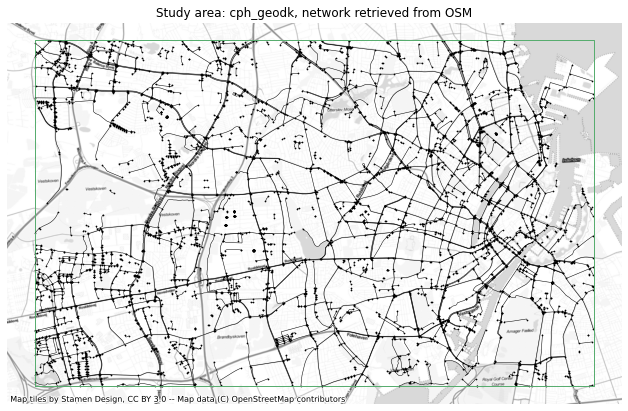

In [6]:
# Plot network

fig, ax = plt.subplots(1, figsize=pdict["fsmap"])

bicycle_edges_simplified.plot(ax=ax, color=pdict["osm_base"], linewidth=0.5)

bicycle_nodes_simplified.plot(ax=ax, color=pdict["osm_base"], markersize=0.5)

study_area_poly.plot(ax=ax, edgecolor=pdict["base"], facecolor="None", linewidth=1)

cx.add_basemap(ax=ax, crs=study_area_poly.crs, source=cx_tile_2)

ax.set_axis_off()

ax.set_title(f"Study area: {study_area}, network retrieved from OSM")

fig.savefig(osm_results_static_maps_fp + "area_network_OSM.png", dpi=pdict["dpi"])

In [7]:
# Joining grid cell id to network elements
osm_edges_simp_joined = gpd.overlay(
    bicycle_edges_simplified.reset_index(), grid, how="intersection"
)
osm_edges_joined = gpd.overlay(bicycle_edges.reset_index(), grid, how="intersection")

osm_nodes_simp_joined = gpd.overlay(
    bicycle_nodes_simplified.reset_index(), grid, how="intersection"
)
osm_nodes_joined = gpd.overlay(bicycle_nodes.reset_index(), grid, how="intersection")

# Count features in each grid cell
all_data_osm = [
    osm_edges_joined,
    osm_nodes_joined,
    osm_edges_simp_joined,
    osm_nodes_simp_joined,
]
labels_osm = ["osm_edges", "osm_nodes", "osm_simplified_edges", "osm_simplified_nodes"]

for data, label in zip(all_data_osm, labels_osm):

    df = eval_func.count_features_in_grid(data, label)

    grid = eval_func.merge_results(grid, df, "left")

# Recomputing infrastructure length for data joined to grid
osm_edges_simp_joined["length"] = osm_edges_simp_joined["geometry"].length
osm_edges_simp_joined["infrastructure_length"] = osm_edges_simp_joined.apply(
    lambda x: eval_func.measure_infrastructure_length(
        edge=x.geometry,
        geometry_type=x.bicycle_geometries,
        bidirectional=x.bicycle_bidirectional,
        bicycle_infrastructure=x.bicycle_infrastructure,
    ),
    axis=1,
)

assert round(bicycle_edges_simplified.infrastructure_length.sum() / 10000, 0) == round(
    osm_edges_simp_joined.infrastructure_length.sum() / 10000, 0
)

In [8]:
# Save data
bicycle_nodes["osmid"] = bicycle_nodes.index
bicycle_nodes_simplified["osmid"] = bicycle_nodes_simplified.index
assert len(bicycle_nodes) == len(bicycle_nodes.osmid.unique())
assert len(bicycle_edges) == len(bicycle_edges.edge_id.unique())
assert len(bicycle_edges_simplified) == len(bicycle_edges_simplified.edge_id.unique())
assert len(bicycle_nodes_simplified) == len(bicycle_nodes_simplified.osmid.unique())

assert "infrastructure_length" in bicycle_edges_simplified.columns
assert "length" in bicycle_edges.columns

with open(osm_nodes_fp, "wb") as f:
    pickle.dump(bicycle_nodes, f)

with open(osm_edges_fp, "wb") as f:
    pickle.dump(bicycle_edges, f)

with open(osm_nodes_simplified_fp, "wb") as f:
    pickle.dump(bicycle_nodes_simplified, f)

with open(osm_edges_simplified_fp, "wb") as f:
    pickle.dump(bicycle_edges_simplified, f)

# Joined data
with open(osm_nodes_joined_fp, "wb") as f:
    pickle.dump(osm_nodes_joined, f)

with open(osm_edges_joined_fp, "wb") as f:
    pickle.dump(osm_edges_joined, f)

with open(osm_nodes_simplified_joined_fp, "wb") as f:
    pickle.dump(osm_nodes_simp_joined, f)

with open(osm_edges_simplified_joined_fp, "wb") as f:
    pickle.dump(osm_edges_simp_joined, f)

print("OSM nodes and edges saved successfully!")

ox.save_graphml(bicycle_graph, osm_graph_fp)
ox.save_graphml(bicycle_graph_simplified, osm_graph_simplified_fp)
print("OSM networks saved successfully!")

data_load_dict = {}

# Save time for when OSM data was loaded
current_time = datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
data_load_dict["data_retrieved_at"] = current_time

with open(osm_meta_fp, "w") as outfile:
    json.dump(data_load_dict, outfile)

OSM nodes and edges saved successfully!
OSM networks saved successfully!


In [9]:
# Export grid
grid.to_file(osm_grid_fp)
print("OSM grid saved successfully!")

OSM grid saved successfully!
